In [1]:
import sys

sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader
from datasets import load_from_disk
from src.hyperdas.data_utils import generate_ravel_dataset, get_ravel_collate_fn, filter_dataset

from transformers import AutoTokenizer

/nlp/scr/sjd24/miniconda3/envs/hypernet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("/scr-ssd/sjd24/llama3-8b")

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

collate_fn = get_ravel_collate_fn(tokenizer, add_space_before_target=True, contain_entity_position=True, source_suffix_visibility=False, base_suffix_visibility=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
from src.hyperdas.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/scr-ssd/sjd24/llama3-8b",
    num_editing_heads=32,
    intervention_layer=15,
    subspace_module="ReflectSelect",
    das_dimension=128,
    break_asymmetric=True,
)
hypernetwork = hypernetwork.to("cuda")
hypernetwork.load_model("/scr-ssd/sjd24/city_symmetric/model_epoch_2_step_3450")

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/sailhome/sjd24/HyperDAS/experiments/RAVEL/../../src/hyperdas/llama3/model.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use

In [5]:
from analysis_utils import get_entity_positions, get_example_max_weight_coord, get_max_weight_type, get_run_data
import pandas as pd

from analysis_utils import get_entity_positions, get_example_max_weight_coord, get_max_weight_type, get_run_data
import pandas as pd

sym_df = pd.DataFrame(columns=["Attribute", "Source Position", "Source Subject Token Number", "Base Position", "Base Subject Token Number"])

for attribute in ["Country", "Continent", "Language", "Timezone", "Latitude", "Longitude"]:
    
    print(f"Attribute: {attribute}")
    test_set = load_from_disk(f"./data/city_{attribute.lower()}_test")
    test_set = get_run_data(hypernetwork, tokenizer, test_set)
    
    for d in test_set:
        
        weight = d["intervention_weight"]
        
        (source_entity_position_ids, source_entity_token), (base_entity_position_ids, base_entity_token) = get_entity_positions(d, tokenizer)
        selected_weight = weight[source_entity_position_ids, :]
        selected_weight = selected_weight[:, base_entity_position_ids]
        
        source_coord, base_coord = get_example_max_weight_coord(d, tokenizer)
        
        source_position, base_positon = None, None
        source_tkn_num = len(source_entity_position_ids)
        base_entity_token = len(base_entity_position_ids)
        
        source_intervention_token_type, _, base_intervention_token_type , _ = get_max_weight_type(d, tokenizer)        
        
        if source_coord not in source_entity_position_ids:
            if source_intervention_token_type == "Sentence Last Token":
                source_position = "Sentence Last Token"
            else:
                source_position = "Others"
        else:
            source_position = str(source_entity_position_ids.index(source_coord))
        
        if base_coord not in base_entity_position_ids:
            if base_intervention_token_type == "Sentence Last Token":
                base_position = "Sentence Last Token"
            else:
                base_position = "Others"
        else:
            base_position = str(base_entity_position_ids.index(base_coord))
            
        sym_df.loc[len(sym_df)] = [attribute, source_position, source_tkn_num, base_position, base_entity_token]

Attribute: Country


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Attribute: Continent
Attribute: Language
Attribute: Timezone
Attribute: Latitude
Attribute: Longitude


In [6]:
from src.hyperdas.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/scr-ssd/sjd24/llama3-8b",
    num_editing_heads=32,
    intervention_layer=15,
    subspace_module="ReflectSelect",
    das_dimension=128,
    break_asymmetric=False,
)
hypernetwork = hypernetwork.to("cuda")
hypernetwork.load_model("/scr-ssd/sjd24/city_masked/final_model")

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/sailhome/sjd24/HyperDAS/experiments/RAVEL/../../src/hyperdas/llama3/model.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use

In [7]:
asym_df = pd.DataFrame(columns=["Attribute", "Source Position", "Source Subject Token Number", "Base Position", "Base Subject Token Number"])

for attribute in ["Country", "Continent", "Language", "Timezone", "Latitude", "Longitude"]:
    
    print(f"Attribute: {attribute}")
    test_set = load_from_disk(f"./data/city_{attribute.lower()}_test")
    test_set = get_run_data(hypernetwork, tokenizer, test_set)
    
    for d in test_set:
        
        weight = d["intervention_weight"]
        
        (source_entity_position_ids, source_entity_token), (base_entity_position_ids, base_entity_token) = get_entity_positions(d, tokenizer)
        selected_weight = weight[source_entity_position_ids, :]
        selected_weight = selected_weight[:, base_entity_position_ids]
        
        source_coord, base_coord = get_example_max_weight_coord(d, tokenizer)
        
        source_position, base_positon = None, None
        source_tkn_num = len(source_entity_position_ids)
        base_entity_token = len(base_entity_position_ids)
        
        source_intervention_token_type, _, base_intervention_token_type , _ = get_max_weight_type(d, tokenizer)        
        
        if source_coord not in source_entity_position_ids:
            if source_intervention_token_type == "Sentence Last Token":
                source_position = "Sentence Last Token"
            else:
                source_position = "Others"
        else:
            source_position = str(source_entity_position_ids.index(source_coord))
        
        if base_coord not in base_entity_position_ids:
            if base_intervention_token_type == "Sentence Last Token":
                base_position = "Sentence Last Token"
            else:
                base_position = "Others"
        else:
            base_position = str(base_entity_position_ids.index(base_coord))
            
        asym_df.loc[len(asym_df)] = [attribute, source_position, source_tkn_num, base_position, base_entity_token]

Attribute: Country
Attribute: Continent


Attribute: Language
Attribute: Timezone
Attribute: Latitude
Attribute: Longitude


In [14]:
sym_new_source_position_value = []
sym_new_base_position_value = []

asym_new_source_position_value = []
asym_new_base_position_value = []


for i, row in sym_df.iterrows():
    if row["Source Position"] == "Sentence Last Token":
        sym_new_source_position_value.append("Sentence Last Token")
    elif row["Source Position"] == "Others":
        sym_new_source_position_value.append(f"Others")
    elif row["Source Position"] == "0":
        sym_new_source_position_value.append("1st Entity Token")
    elif row["Source Position"] == "1":
        sym_new_source_position_value.append("2nd Entity Token")
    elif row["Source Position"] == "2":
        sym_new_source_position_value.append("3rd Entity Token")
    else:
        sym_new_source_position_value.append(f"{int(row['Source Position'])+1}th Entity Token")
        
    if row["Base Position"] == "Sentence Last Token":
        sym_new_base_position_value.append("Sentence Last Token")
    elif row["Base Position"] == "Others":
        sym_new_base_position_value.append(f"Others")
    elif row["Base Position"] == "0":
        sym_new_base_position_value.append("1st Entity Token")
    elif row["Base Position"] == "1":
        sym_new_base_position_value.append("2nd Entity Token")
    elif row["Base Position"] == "2":
        sym_new_base_position_value.append("3rd Entity Token")
    else:
        sym_new_base_position_value.append(f"{int(row['Base Position'])+1}th Entity Token")
        
for i, row in asym_df.iterrows():
    if row["Source Position"] == "Sentence Last Token":
        asym_new_source_position_value.append("Sentence Last Token")
    elif row["Source Position"] == "Others":
        asym_new_source_position_value.append(f"Others")
    elif row["Source Position"] == "0":
        asym_new_source_position_value.append("1st Entity Token")
    elif row["Source Position"] == "1":
        asym_new_source_position_value.append("2nd Entity Token")
    elif row["Source Position"] == "2":
        asym_new_source_position_value.append("3rd Entity Token")
    else:
        asym_new_source_position_value.append(f"{int(row['Source Position'])+1}th Entity Token")
        
    if row["Base Position"] == "Sentence Last Token":
        asym_new_base_position_value.append("Sentence Last Token")
    elif row["Base Position"] == "Others":
        asym_new_base_position_value.append(f"Others")
    elif row["Base Position"] == "0":
        asym_new_base_position_value.append("1st Entity Token")
    elif row["Base Position"] == "1":
        asym_new_base_position_value.append("2nd Entity Token")
    elif row["Base Position"] == "2":
        asym_new_base_position_value.append("3rd Entity Token")
    else:
        asym_new_base_position_value.append(f"{int(row['Base Position'])+1}th Entity Token")

In [16]:
sym_df["Source Position (Text)"] = sym_new_source_position_value
sym_df["Base Position (Text)"] = sym_new_base_position_value

asym_df["Source Position (Text)"] = asym_new_source_position_value
asym_df["Base Position (Text)"] = asym_new_base_position_value

/tmp/user/24141/ipykernel_517771/2731857698.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0][0].legend().remove()
/tmp/user/24141/ipykernel_517771/2731857698.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1][0].legend().remove()
/tmp/user/24141/ipykernel_517771/2731857698.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1][1].legend().remove()
/tmp/user/24141/ipykernel_517771/2731857698.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), fontsi

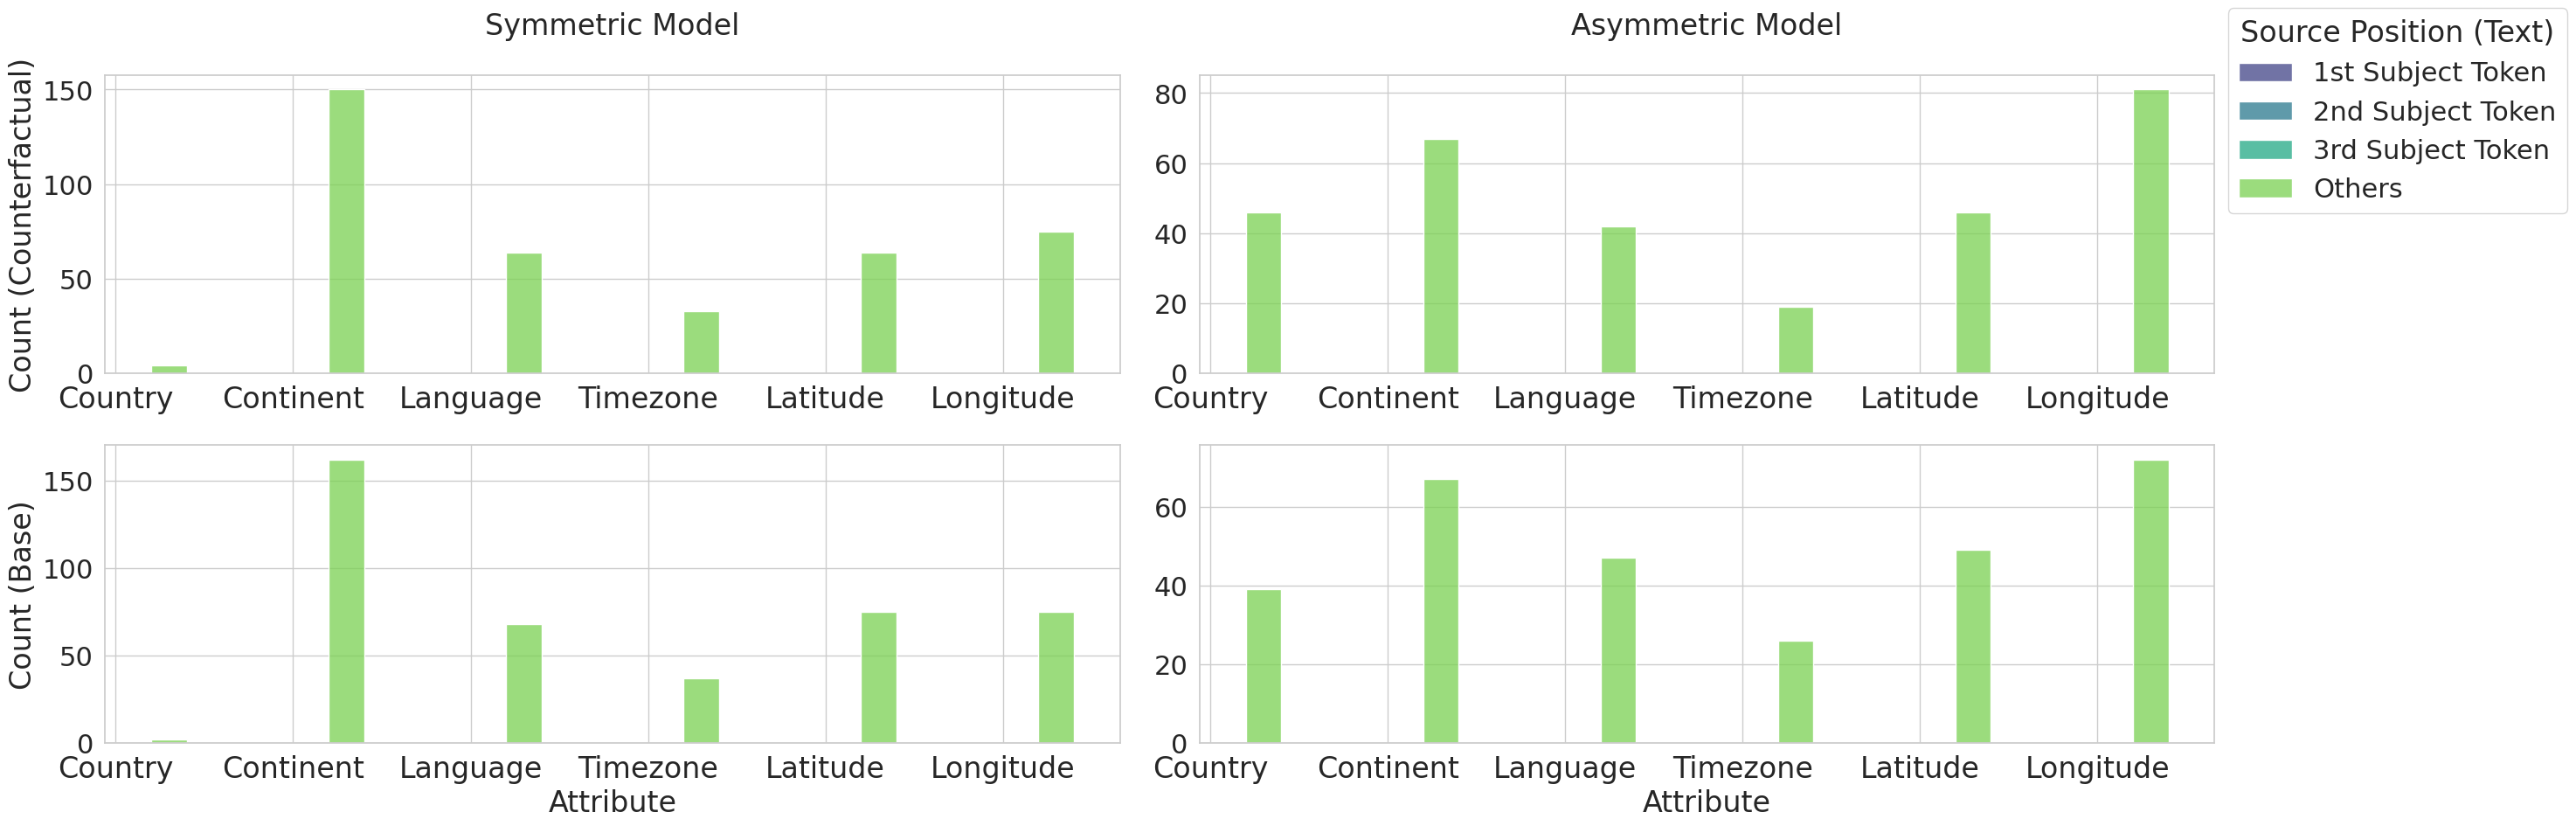

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=2)
fig, axes = plt.subplots(2, 2, figsize=(30, 10))


sym_three_token_base_df = sym_df[sym_df["Base Subject Token Number"] == 3]
sym_three_token_source_df = sym_df[sym_df["Source Subject Token Number"] == 3]

sym_three_token_base_df = sym_three_token_base_df[sym_three_token_base_df["Base Position (Text)"] != "Sentence Last Token"]
sym_three_token_source_df = sym_three_token_source_df[sym_three_token_source_df["Source Position (Text)"] != "Sentence Last Token"]

asym_three_token_base_df = asym_df[asym_df["Base Subject Token Number"] == 3]
asym_three_token_source_df = asym_df[asym_df["Source Subject Token Number"] == 3]

asym_three_token_base_df = asym_three_token_base_df[asym_three_token_base_df["Base Position (Text)"] != "Sentence Last Token"]
asym_three_token_source_df = asym_three_token_source_df[asym_three_token_source_df["Source Position (Text)"] != "Sentence Last Token"]


order = ["1st Entity Token", "2nd Entity Token", "3rd Entity Token", "Others"]

# Plot a histogram of the base position, grouped by "Attribute", add interval between each group
sns.histplot(data=sym_three_token_source_df, x="Attribute", hue="Source Position (Text)", multiple="dodge", ax=axes[0][0], palette="viridis", hue_order=order, shrink=0.8)
sns.histplot(data=sym_three_token_base_df, x="Attribute", hue="Base Position (Text)", multiple="dodge", ax=axes[1][0], palette="viridis", hue_order=order, shrink=0.8)
sns.histplot(data=asym_three_token_source_df, x="Attribute", hue="Source Position (Text)", multiple="dodge", ax=axes[0][1], palette="viridis", hue_order=order, shrink=0.8)
sns.histplot(data=asym_three_token_base_df, x="Attribute", hue="Base Position (Text)", multiple="dodge", ax=axes[1][1], palette="viridis", hue_order=order, shrink=0.8)

axes[0][0].set_xlabel("")
axes[0][1].set_xlabel("")

axes[0][1].set_ylabel("")
axes[1][1].set_ylabel("")

axes[0][0].set_ylabel("Count (Counterfactual)")
axes[1][0].set_ylabel("Count (Base)")


axes[0][0].legend().remove() 
axes[1][0].legend().remove() 
axes[1][1].legend().remove() 

axes[0][0].set_title("Symmetric Model\n")
axes[0][1].set_title("Asymmetric Model\n")

    
for i in range(2):
    for j in range(2):
        axes[i][j].set_xticklabels(axes[i][j].get_xticklabels(), fontsize=24)
    
"""axes[0][1].legend(
    title="Intervention Position",
    title_fontsize=14,
    labels=["1st Subject Token", "2nd Subject Token", "3rd Subject Token", "Sentence Last Token", "Others"],
    fontsize=14,
    loc="upper right",
)"""

legend = axes[0][1].get_legend()

# Move legend to the upper right corner
legend.set_bbox_to_anchor((1, 1.27))

plt.tight_layout()
fig.savefig("subject_tkn_position.pdf")


In [12]:
asym_three_token_source_df

,Attribute,Source Position,Source Subject Token Number,Base Position,Base Subject Token Number,Source Position (Text),Base Position (Text)
1,Country,2,3,1,3,3rd Subject Token,2nd Subject Token
2,Country,2,3,1,2,3rd Subject Token,2nd Subject Token
4,Country,2,3,0,2,3rd Subject Token,1st Subject Token
6,Country,2,3,0,2,3rd Subject Token,1st Subject Token
8,Country,2,3,1,2,3rd Subject Token,2nd Subject Token
...,...,...,...,...,...,...,...
7005,Longitude,2,3,1,3,3rd Subject Token,2nd Subject Token
7006,Longitude,Others,3,Others,2,Others,Others
7008,Longitude,2,3,0,2,3rd Subject Token,1st Subject Token
7009,Longitude,2,3,0,2,3rd Subject Token,1st Subject Token


In [13]:
"""import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.random.seed(0)

# Generate sample data
base_data = []
sym_data = []
asym_data = []

delta_data = []

grey = sns.color_palette("muted")[7]
pallet = sns.color_palette("viridis")
sym_color = pallet[2]
asym_color = pallet[-1]

for attribute in ["Country", "Continent", "Language", "Timezone", "Latitude", "Longitude"]:
    
    attribute_asym_df = sym_three_token_base_df[sym_three_token_base_df["Attribute"] == attribute]
    attribute_sym_df = asym_three_token_base_df[asym_three_token_base_df["Attribute"] == attribute]

    asym_density = len(attribute_asym_df[attribute_asym_df["Base Position"] == "3rd Subject Token"]) / len(attribute_asym_df)
    sym_density = len(attribute_sym_df[attribute_sym_df["Base Position"] == "3rd Subject Token"]) / len(attribute_sym_df)
    print(f"Symmetric Density: {sym_density}")
    print(f"Asymmetric Density: {asym_density}")
    
    
    sym_data.extend([attribute]*int(sym_density*100))
    asym_data.extend([attribute]*int(asym_density*100))
    base_data.extend([attribute]*(100 - int(sym_density*100) - int(asym_density*100)))
    delta_data.append(sym_density - asym_density)
    

# Plot the stacked histogram
plt.hist(
    [sym_data, base_data, asym_data], 
    bins=35, stacked=True, label=['Sym', '', 'Asym'], color=[sym_color, grey, asym_color],
    orientation='horizontal'
)

# Add labels and title
plt.xlabel('Percentage of Cases')
plt.xlim(0, 100)
plt.ylabel('')
plt.title('')


# Plot the delta data in text to all the bins

for i, delta in enumerate(delta_data):
    delta = delta * 100
    plt.text(0, i - 0.3, f"+{delta:.1f}%", color='black', fontsize=14)

# Remove x-tick labels
plt.xticks([0, 20, 40, 60, 80, 100], ['0%', '20%', '40%', '60%', '80%', '100%'])

# Move the legend to the bottom right
plt.legend(loc='lower right')
"""

'import matplotlib.pyplot as plt\nimport numpy as np\nimport seaborn as sns\n\nnp.random.seed(0)\n\n# Generate sample data\nbase_data = []\nsym_data = []\nasym_data = []\n\ndelta_data = []\n\ngrey = sns.color_palette("muted")[7]\npallet = sns.color_palette("viridis")\nsym_color = pallet[2]\nasym_color = pallet[-1]\n\nfor attribute in ["Country", "Continent", "Language", "Timezone", "Latitude", "Longitude"]:\n    \n    attribute_asym_df = sym_three_token_base_df[sym_three_token_base_df["Attribute"] == attribute]\n    attribute_sym_df = asym_three_token_base_df[asym_three_token_base_df["Attribute"] == attribute]\n\n    asym_density = len(attribute_asym_df[attribute_asym_df["Base Position"] == "3rd Subject Token"]) / len(attribute_asym_df)\n    sym_density = len(attribute_sym_df[attribute_sym_df["Base Position"] == "3rd Subject Token"]) / len(attribute_sym_df)\n    print(f"Symmetric Density: {sym_density}")\n    print(f"Asymmetric Density: {asym_density}")\n    \n    \n    sym_data.extend